In [718]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Loading Data

In [660]:
games = pd.read_csv('data/raw/games.csv')
appearances = pd.read_csv('data/raw/appearances.csv')
clubs = pd.read_csv('data/raw/clubs.csv')
player_valuations = pd.read_csv('data/raw/player_valuations.csv')
competitions = pd.read_csv('data/raw/competitions.csv')

### Games Data

In [661]:
games.head()

,game_id,competition_id,season,round,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,...,stadium,attendance,referee,url,home_club_formation,away_club_formation,home_club_name,away_club_name,aggregate,competition_type
0,2321027,L1,2013,1. Matchday,2013-08-11,33.0,41.0,3.0,3.0,8.0,...,Veltins-Arena,61973.0,Manuel Gräfe,https://www.transfermarkt.co.uk/fc-schalke-04_...,4-2-3-1,4-2-3-1,FC Schalke 04,Hamburger SV,3:3,domestic_league
1,2321033,L1,2013,1. Matchday,2013-08-10,23.0,86.0,0.0,1.0,13.0,...,EINTRACHT-Stadion,23000.0,Deniz Aytekin,https://www.transfermarkt.co.uk/eintracht-brau...,4-3-2-1,4-3-1-2,Eintracht Braunschweig,Sportverein Werder Bremen von 1899,0:1,domestic_league
2,2321044,L1,2013,2. Matchday,2013-08-18,16.0,23.0,2.0,1.0,1.0,...,SIGNAL IDUNA PARK,80200.0,Peter Sippel,https://www.transfermarkt.co.uk/borussia-dortm...,4-2-3-1,4-3-2-1,Borussia Dortmund,Eintracht Braunschweig,2:1,domestic_league
3,2321060,L1,2013,3. Matchday,2013-08-25,23.0,24.0,0.0,2.0,18.0,...,EINTRACHT-Stadion,23325.0,Wolfgang Stark,https://www.transfermarkt.co.uk/eintracht-brau...,4-3-2-1,4-2-3-1,Eintracht Braunschweig,Eintracht Frankfurt Fußball AG,0:2,domestic_league
4,2321072,L1,2013,5. Matchday,2013-09-14,16.0,41.0,6.0,2.0,1.0,...,SIGNAL IDUNA PARK,80645.0,Tobias Welz,https://www.transfermarkt.co.uk/borussia-dortm...,4-2-3-1,3-5-2,Borussia Dortmund,Hamburger SV,6:2,domestic_league


In [662]:
columns_to_drop = [
    'round',
    'home_club_manager_name',
    'away_club_manager_name', 
    'stadium',
    'referee',
    'url',
    'home_club_formation',
    'away_club_formation',
    'home_club_name',
    'away_club_name',
    'competition_type',
    'aggregate'
]
games.drop(columns=columns_to_drop, inplace=True)
games.head()

,game_id,competition_id,season,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,away_club_position,attendance
0,2321027,L1,2013,2013-08-11,33.0,41.0,3.0,3.0,8.0,9.0,61973.0
1,2321033,L1,2013,2013-08-10,23.0,86.0,0.0,1.0,13.0,7.0,23000.0
2,2321044,L1,2013,2013-08-18,16.0,23.0,2.0,1.0,1.0,15.0,80200.0
3,2321060,L1,2013,2013-08-25,23.0,24.0,0.0,2.0,18.0,11.0,23325.0
4,2321072,L1,2013,2013-09-14,16.0,41.0,6.0,2.0,1.0,15.0,80645.0


In [663]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74026 entries, 0 to 74025
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   game_id             74026 non-null  int64  
 1   competition_id      74026 non-null  object 
 2   season              74026 non-null  int64  
 3   date                74026 non-null  object 
 4   home_club_id        74017 non-null  float64
 5   away_club_id        74017 non-null  float64
 6   home_club_goals     74014 non-null  float64
 7   away_club_goals     74014 non-null  float64
 8   home_club_position  51559 non-null  float64
 9   away_club_position  51559 non-null  float64
 10  attendance          64078 non-null  float64
dtypes: float64(7), int64(2), object(2)
memory usage: 6.2+ MB


In [664]:
games.dropna(subset=['home_club_id', 'away_club_id', 'home_club_goals', 'away_club_goals'], inplace=True)
games['home_club_position'] = games['home_club_position'].fillna(0)
games['away_club_position'] = games['away_club_position'].fillna(0)
attendance_mean = games['attendance'].mean()
games['attendance'] = games['attendance'].fillna(attendance_mean)
games['target'] = games.apply(
    lambda x: 'home_win' if x['home_club_goals'] > x['away_club_goals'] else 
                'away_win' if x['away_club_goals'] > x['home_club_goals'] else 'draw', 
    axis=1
)

In [665]:
games['home_club_id'] = games['home_club_id'].astype(int)
games['away_club_id'] = games['away_club_id'].astype(int)
games['home_club_goals'] = games['home_club_goals'].astype(int)
games['away_club_goals'] = games['away_club_goals'].astype(int)
games['home_club_position'] = games['home_club_position'].astype(int)
games['away_club_position'] = games['away_club_position'].astype(int)
games['attendance'] = games['attendance'].astype(int)
games['date'] = pd.to_datetime(games['date'])
games.head()

,game_id,competition_id,season,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,away_club_position,attendance,target
0,2321027,L1,2013,2013-08-11,33,41,3,3,8,9,61973,draw
1,2321033,L1,2013,2013-08-10,23,86,0,1,13,7,23000,away_win
2,2321044,L1,2013,2013-08-18,16,23,2,1,1,15,80200,home_win
3,2321060,L1,2013,2013-08-25,23,24,0,2,18,11,23325,away_win
4,2321072,L1,2013,2013-09-14,16,41,6,2,1,15,80645,home_win


In [666]:
games.isnull().sum()

game_id               0
competition_id        0
season                0
date                  0
home_club_id          0
away_club_id          0
home_club_goals       0
away_club_goals       0
home_club_position    0
away_club_position    0
attendance            0
target                0
dtype: int64

In [667]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74014 entries, 0 to 74025
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   game_id             74014 non-null  int64         
 1   competition_id      74014 non-null  object        
 2   season              74014 non-null  int64         
 3   date                74014 non-null  datetime64[ns]
 4   home_club_id        74014 non-null  int64         
 5   away_club_id        74014 non-null  int64         
 6   home_club_goals     74014 non-null  int64         
 7   away_club_goals     74014 non-null  int64         
 8   home_club_position  74014 non-null  int64         
 9   away_club_position  74014 non-null  int64         
 10  attendance          74014 non-null  int64         
 11  target              74014 non-null  object        
dtypes: datetime64[ns](1), int64(9), object(2)
memory usage: 7.3+ MB


In [668]:
games.to_parquet('features/games_final.parquet')

In [669]:
del games

### Appearances Data

In [670]:
appearances.head()

,appearance_id,game_id,player_id,player_club_id,player_current_club_id,date,player_name,competition_id,yellow_cards,red_cards,goals,assists,minutes_played
0,2231978_38004,2231978,38004,853,235,2012-07-03,Aurélien Joachim,CLQ,0,0,2,0,90
1,2233748_79232,2233748,79232,8841,2698,2012-07-05,Ruslan Abyshov,ELQ,0,0,0,0,90
2,2234413_42792,2234413,42792,6251,465,2012-07-05,Sander Puri,ELQ,0,0,0,0,45
3,2234418_73333,2234418,73333,1274,6646,2012-07-05,Vegar Hedenstad,ELQ,0,0,0,0,90
4,2234421_122011,2234421,122011,195,3008,2012-07-05,Markus Henriksen,ELQ,0,0,0,1,90


In [671]:
appearances.isnull().sum()

appearance_id             0
game_id                   0
player_id                 0
player_club_id            0
player_current_club_id    0
date                      0
player_name               6
competition_id            0
yellow_cards              0
red_cards                 0
goals                     0
assists                   0
minutes_played            0
dtype: int64

In [672]:
columns_to_drop = ['appearance_id', 'player_name', 'player_current_club_id']
appearances.drop(columns=columns_to_drop, inplace=True)
appearances['date'] = pd.to_datetime(appearances['date'])
appearances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1706806 entries, 0 to 1706805
Data columns (total 10 columns):
 #   Column          Dtype         
---  ------          -----         
 0   game_id         int64         
 1   player_id       int64         
 2   player_club_id  int64         
 3   date            datetime64[ns]
 4   competition_id  object        
 5   yellow_cards    int64         
 6   red_cards       int64         
 7   goals           int64         
 8   assists         int64         
 9   minutes_played  int64         
dtypes: datetime64[ns](1), int64(8), object(1)
memory usage: 130.2+ MB


In [673]:
squad_stats = appearances.groupby(['game_id', 'player_club_id']).agg({          
    'goals': 'sum',                 
    'assists': 'sum',               
    'minutes_played': ['sum', 'mean', 'max'],
    'yellow_cards': 'sum',          
    'red_cards': 'sum'
}).reset_index()

squad_stats.columns = [
    'game_id', 'club_id', 
    'squad_goals', 'squad_assists',
    'total_minutes', 'avg_minutes', 'max_minutes', 'yellows', 'reds'
]

squad_stats.head()

,game_id,club_id,squad_goals,squad_assists,total_minutes,avg_minutes,max_minutes,yellows,reds
0,2211607,383,4,4,990,76.153846,90,2,0
1,2211607,610,1,2,990,70.714286,90,5,0
2,2218677,506,3,4,1320,94.285714,120,3,0
3,2218677,6195,2,0,1256,89.714286,120,6,1
4,2219794,58,3,2,990,70.714286,90,2,0


In [674]:
squad_stats.to_parquet('features/squad_stats.parquet')

In [675]:
del appearances

### Clubs Data

In [676]:
clubs.head()

,club_id,club_code,name,domestic_competition_id,total_market_value,squad_size,average_age,foreigners_number,foreigners_percentage,national_team_players,stadium_name,stadium_seats,net_transfer_record,coach_name,last_season,filename,url
0,105,sv-darmstadt-98,SV Darmstadt 98,L1,NaN,27,25.6,13,48.1,1,Merck-Stadion am Böllenfalltor,17810,+€3.05m,NaN,2023,../data/raw/transfermarkt-scraper/2023/clubs.j...,https://www.transfermarkt.co.uk/sv-darmstadt-9...
1,11127,ural-ekaterinburg,Ural Yekaterinburg,RU1,NaN,30,26.5,11,36.7,3,Yekaterinburg Arena,23000,+€880k,NaN,2023,../data/raw/transfermarkt-scraper/2023/clubs.j...,https://www.transfermarkt.co.uk/ural-ekaterinb...
2,114,besiktas-istanbul,Beşiktaş Jimnastik Kulübü,TR1,NaN,30,26.6,15,50.0,8,Beşiktaş Park,42445,€-25.26m,NaN,2024,../data/raw/transfermarkt-scraper/2024/clubs.j...,https://www.transfermarkt.co.uk/besiktas-istan...
3,12,as-rom,Associazione Sportiva Roma,IT1,NaN,26,26.3,18,69.2,17,Olimpico di Roma,70634,€-76.90m,NaN,2024,../data/raw/transfermarkt-scraper/2024/clubs.j...,https://www.transfermarkt.co.uk/as-rom/startse...
4,148,tottenham-hotspur,Tottenham Hotspur Football Club,GB1,NaN,30,25.5,21,70.0,18,Tottenham Hotspur Stadium,62850,€-120.05m,NaN,2024,../data/raw/transfermarkt-scraper/2024/clubs.j...,https://www.transfermarkt.co.uk/tottenham-hots...


In [677]:
columns_to_drop = [
    'filename', 
    'url', 
    'coach_name', 
    'stadium_name', 
    'club_code', 
    'name',
    'total_market_value',
    'foreigners_number',
    'net_transfer_record'
]

clubs.drop(columns=columns_to_drop, inplace=True)

In [678]:
clubs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 439 entries, 0 to 438
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   club_id                  439 non-null    int64  
 1   domestic_competition_id  439 non-null    object 
 2   squad_size               439 non-null    int64  
 3   average_age              401 non-null    float64
 4   foreigners_percentage    390 non-null    float64
 5   national_team_players    439 non-null    int64  
 6   stadium_seats            439 non-null    int64  
 7   last_season              439 non-null    int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 27.6+ KB


In [679]:
clubs['foreigners_percentage'] = clubs['foreigners_percentage'].fillna(clubs['foreigners_percentage'].mean())
clubs['average_age'] = clubs['average_age'].fillna(clubs['average_age'].mean())
clubs.isnull().sum()

club_id                    0
domestic_competition_id    0
squad_size                 0
average_age                0
foreigners_percentage      0
national_team_players      0
stadium_seats              0
last_season                0
dtype: int64

In [680]:
clubs.to_parquet('features/club_features.parquet')
del clubs

### Player Valuations Data

In [681]:
player_valuations.head()

,player_id,date,market_value_in_eur,current_club_id,player_club_domestic_competition_id
0,405973,2000-01-20,150000,3057,BE1
1,342216,2001-07-20,100000,1241,SC1
2,3132,2003-12-09,400000,126,TR1
3,6893,2003-12-15,900000,984,GB1
4,10,2004-10-04,7000000,398,IT1


In [682]:
player_valuations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496606 entries, 0 to 496605
Data columns (total 5 columns):
 #   Column                               Non-Null Count   Dtype 
---  ------                               --------------   ----- 
 0   player_id                            496606 non-null  int64 
 1   date                                 496606 non-null  object
 2   market_value_in_eur                  496606 non-null  int64 
 3   current_club_id                      496606 non-null  int64 
 4   player_club_domestic_competition_id  496606 non-null  object
dtypes: int64(3), object(2)
memory usage: 18.9+ MB


In [683]:
player_valuations.isnull().sum()

player_id                              0
date                                   0
market_value_in_eur                    0
current_club_id                        0
player_club_domestic_competition_id    0
dtype: int64

In [684]:
player_valuations['date'] = pd.to_datetime(player_valuations['date'])
player_valuations.dtypes

player_id                                       int64
date                                   datetime64[ns]
market_value_in_eur                             int64
current_club_id                                 int64
player_club_domestic_competition_id            object
dtype: object

In [685]:
player_valuations.head()

,player_id,date,market_value_in_eur,current_club_id,player_club_domestic_competition_id
0,405973,2000-01-20,150000,3057,BE1
1,342216,2001-07-20,100000,1241,SC1
2,3132,2003-12-09,400000,126,TR1
3,6893,2003-12-15,900000,984,GB1
4,10,2004-10-04,7000000,398,IT1


In [686]:
player_valuations.drop(columns='player_club_domestic_competition_id', inplace=True)
valuation_features = player_valuations.groupby(['current_club_id', 'date']).agg({
    'market_value_in_eur': ['sum', 'mean', 'max', 'count']
}).reset_index()
valuation_features.columns = [
    'club_id', 
    'date', 
    'total_squad_value', 
    'avg_player_value', 
    'max_player_value', 
    'valued_players_count'
]
valuation_features.head()

,club_id,date,total_squad_value,avg_player_value,max_player_value,valued_players_count
0,3,2004-10-04,1025000,128125.0,500000,8
1,3,2004-10-16,200000,200000.0,200000,1
2,3,2004-10-20,400000,400000.0,400000,1
3,3,2004-11-29,50000,50000.0,50000,1
4,3,2005-01-14,750000,750000.0,750000,1


In [687]:
valuation_features.to_parquet('features/valuation_features.parquet')
del player_valuations

# Merge Datasets & Filtering Data

In [688]:
games = pd.read_parquet('features/games_final.parquet')
squad_stats = pd.read_parquet('features/squad_stats.parquet') 
club_features = pd.read_parquet('features/club_features.parquet')
valuation_features = pd.read_parquet('features/valuation_features.parquet')

In [689]:
home_squad = squad_stats.rename(columns={
    'club_id': 'home_club_id',
    'squad_goals': 'home_squad_goals', 
    'squad_assists': 'home_squad_assists',
    'total_minutes': 'home_total_minutes',
    'avg_minutes': 'home_avg_minutes',
    'max_minutes': 'home_max_minutes', 
    'yellows': 'home_yellows',
    'reds': 'home_reds'
})

away_squad = squad_stats.rename(columns={
    'club_id': 'away_club_id', 
    'squad_goals': 'away_squad_goals',
    'squad_assists': 'away_squad_assists',
    'total_minutes': 'away_total_minutes',
    'avg_minutes': 'away_avg_minutes',
    'max_minutes': 'away_max_minutes',
    'yellows': 'away_yellows', 
    'reds': 'away_reds'
})

final_data = games.merge(home_squad, on=['game_id', 'home_club_id'], how='left')
final_data = final_data.merge(away_squad, on=['game_id', 'away_club_id'], how='left')

final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74014 entries, 0 to 74013
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   game_id             74014 non-null  int64         
 1   competition_id      74014 non-null  object        
 2   season              74014 non-null  int64         
 3   date                74014 non-null  datetime64[ns]
 4   home_club_id        74014 non-null  int64         
 5   away_club_id        74014 non-null  int64         
 6   home_club_goals     74014 non-null  int64         
 7   away_club_goals     74014 non-null  int64         
 8   home_club_position  74014 non-null  int64         
 9   away_club_position  74014 non-null  int64         
 10  attendance          74014 non-null  int64         
 11  target              74014 non-null  object        
 12  home_squad_goals    62617 non-null  float64       
 13  home_squad_assists  62617 non-null  float64   

In [690]:
final_data.isnull().sum()

game_id                   0
competition_id            0
season                    0
date                      0
home_club_id              0
away_club_id              0
home_club_goals           0
away_club_goals           0
home_club_position        0
away_club_position        0
attendance                0
target                    0
home_squad_goals      11397
home_squad_assists    11397
home_total_minutes    11397
home_avg_minutes      11397
home_max_minutes      11397
home_yellows          11397
home_reds             11397
away_squad_goals      10178
away_squad_assists    10178
away_total_minutes    10178
away_avg_minutes      10178
away_max_minutes      10178
away_yellows          10178
away_reds             10178
dtype: int64

In [691]:
final_data = final_data.dropna(subset=[
    'home_squad_goals',
    'away_squad_goals'
])

final_data.info()                               

<class 'pandas.core.frame.DataFrame'>
Index: 59613 entries, 0 to 74013
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   game_id             59613 non-null  int64         
 1   competition_id      59613 non-null  object        
 2   season              59613 non-null  int64         
 3   date                59613 non-null  datetime64[ns]
 4   home_club_id        59613 non-null  int64         
 5   away_club_id        59613 non-null  int64         
 6   home_club_goals     59613 non-null  int64         
 7   away_club_goals     59613 non-null  int64         
 8   home_club_position  59613 non-null  int64         
 9   away_club_position  59613 non-null  int64         
 10  attendance          59613 non-null  int64         
 11  target              59613 non-null  object        
 12  home_squad_goals    59613 non-null  float64       
 13  home_squad_assists  59613 non-null  float64       


In [692]:
final_data = final_data.merge(
    club_features.add_prefix('home_'), 
    left_on='home_club_id',
    right_on='home_club_id',
    how='left'
)

final_data = final_data.merge(
    club_features.add_prefix('away_'),
    left_on='away_club_id', 
    right_on='away_club_id',
    how='left'
)

In [693]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59613 entries, 0 to 59612
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   game_id                       59613 non-null  int64         
 1   competition_id                59613 non-null  object        
 2   season                        59613 non-null  int64         
 3   date                          59613 non-null  datetime64[ns]
 4   home_club_id                  59613 non-null  int64         
 5   away_club_id                  59613 non-null  int64         
 6   home_club_goals               59613 non-null  int64         
 7   away_club_goals               59613 non-null  int64         
 8   home_club_position            59613 non-null  int64         
 9   away_club_position            59613 non-null  int64         
 10  attendance                    59613 non-null  int64         
 11  target                      

In [694]:
final_data = final_data.dropna(subset=['home_squad_size', 'away_squad_size'])
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57256 entries, 0 to 59590
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   game_id                       57256 non-null  int64         
 1   competition_id                57256 non-null  object        
 2   season                        57256 non-null  int64         
 3   date                          57256 non-null  datetime64[ns]
 4   home_club_id                  57256 non-null  int64         
 5   away_club_id                  57256 non-null  int64         
 6   home_club_goals               57256 non-null  int64         
 7   away_club_goals               57256 non-null  int64         
 8   home_club_position            57256 non-null  int64         
 9   away_club_position            57256 non-null  int64         
 10  attendance                    57256 non-null  int64         
 11  target                        572

In [695]:
final_data.to_parquet('features/final_dataset_clean.parquet')
del final_data

# Charts

In [696]:
df = pd.read_parquet('features/final_dataset_clean.parquet')
df.head()

,game_id,competition_id,season,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,away_club_position,...,home_national_team_players,home_stadium_seats,home_last_season,away_domestic_competition_id,away_squad_size,away_average_age,away_foreigners_percentage,away_national_team_players,away_stadium_seats,away_last_season
0,2321027,L1,2013,2013-08-11,33,41,3,3,8,9,...,4.0,62271.0,2022.0,L1,30.0,23.6,50.0,4.0,57000.0,2017.0
1,2321033,L1,2013,2013-08-10,23,86,0,1,13,7,...,2.0,23325.0,2013.0,L1,27.0,26.6,44.4,6.0,42100.0,2024.0
2,2321044,L1,2013,2013-08-18,16,23,2,1,1,15,...,18.0,81365.0,2024.0,L1,30.0,25.6,36.7,2.0,23325.0,2013.0
3,2321060,L1,2013,2013-08-25,23,24,0,2,18,11,...,2.0,23325.0,2013.0,L1,27.0,25.4,74.1,10.0,58000.0,2024.0
4,2321072,L1,2013,2013-09-14,16,41,6,2,1,15,...,18.0,81365.0,2024.0,L1,30.0,23.6,50.0,4.0,57000.0,2017.0


### Distribution of match outcomes

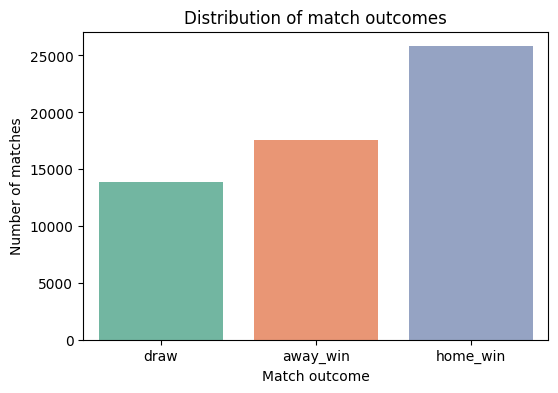

In [697]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='target', hue='target', palette='Set2', legend=False)
plt.title('Distribution of match outcomes')
plt.xlabel('Match outcome')
plt.ylabel('Number of matches')
plt.show()

### Home and Away Goal Breakdown

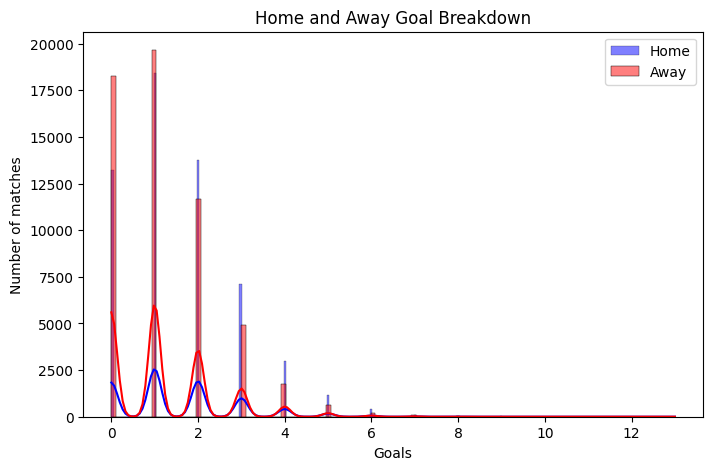

In [698]:
plt.figure(figsize=(8,5))
sns.histplot(df['home_club_goals'], color='blue', label='Home', kde=True)
sns.histplot(df['away_club_goals'], color='red', label='Away', kde=True)
plt.legend()
plt.title('Home and Away Goal Breakdown')
plt.xlabel('Goals')
plt.ylabel('Number of matches')
plt.show()

### Distribution of important features by outcome

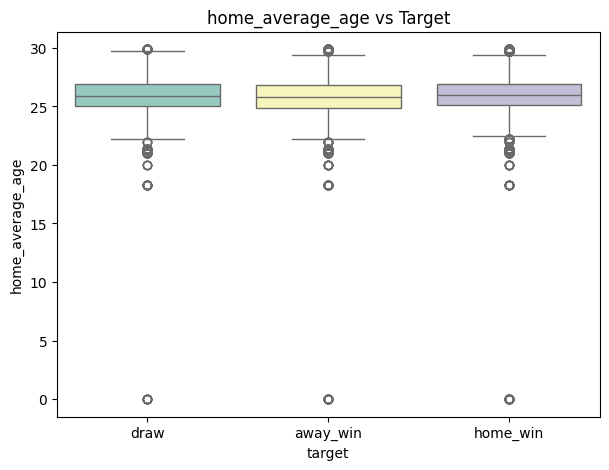

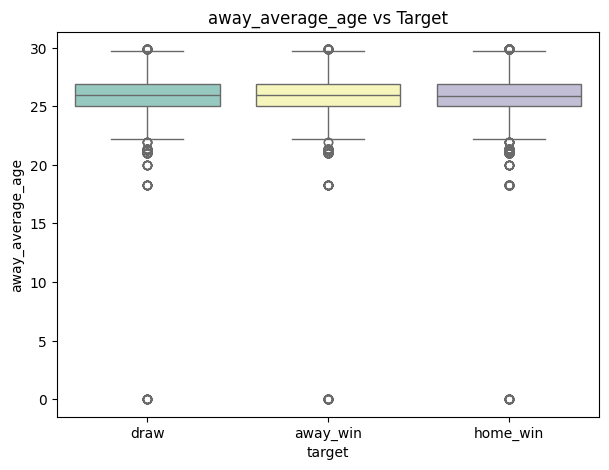

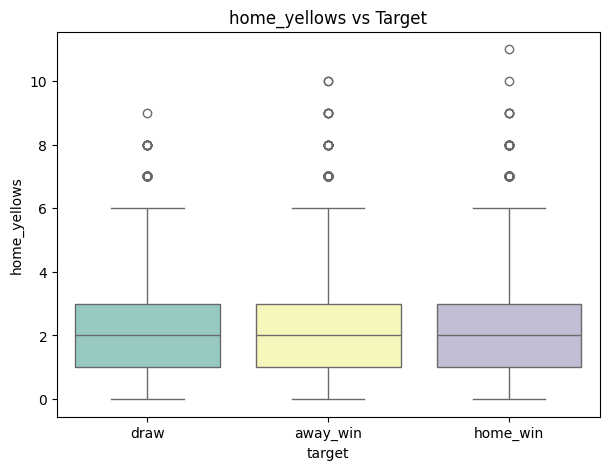

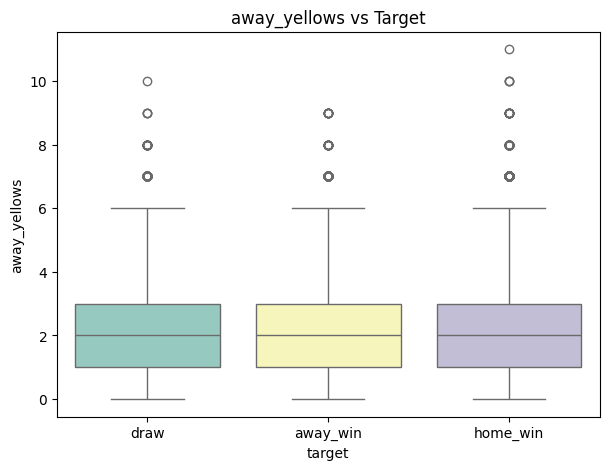

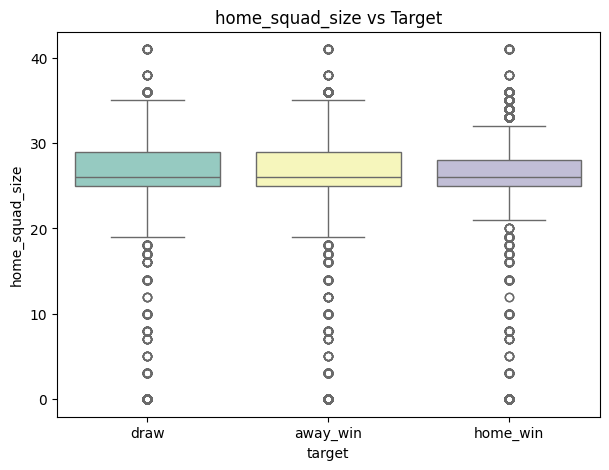

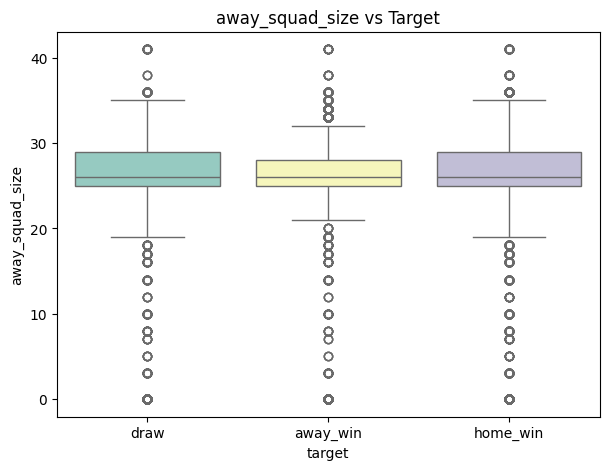

In [699]:
features = ['home_average_age', 'away_average_age', 'home_yellows', 'away_yellows', 'home_squad_size', 'away_squad_size']

for f in features:
    plt.figure(figsize=(7,5))
    sns.boxplot(x='target', y=f, data=df, hue='target', palette='Set3', legend=False)
    plt.title(f'{f} vs Target')
    plt.show()

### The difference between the home and away team

In [700]:
df['goal_diff'] = df['home_club_goals'] - df['away_club_goals']
df['squad_size_diff'] = df['home_squad_size'] - df['away_squad_size']
df['age_diff'] = df['home_average_age'] - df['away_average_age']
df['yellows_diff'] = df['home_yellows'] - df['away_yellows']

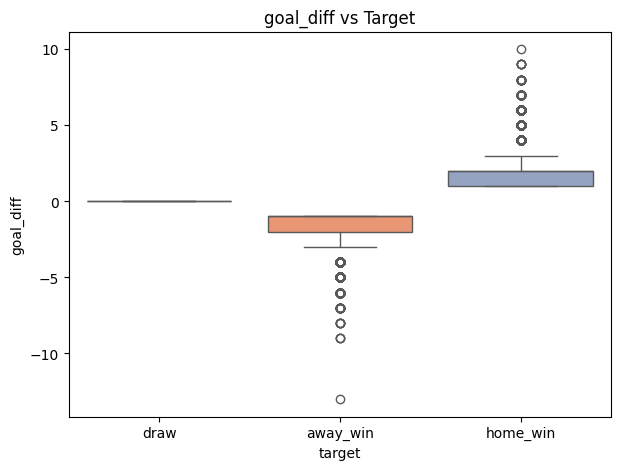

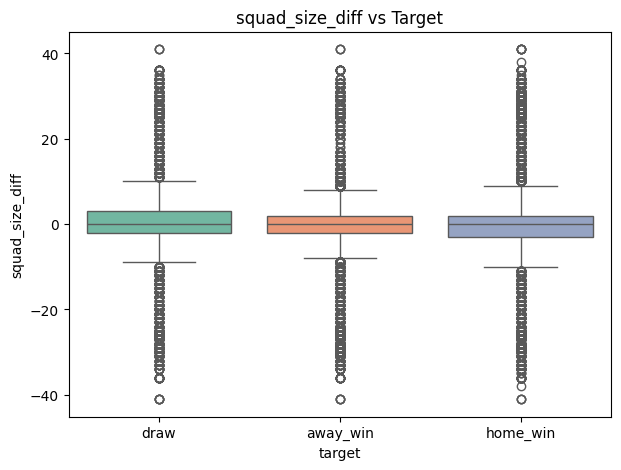

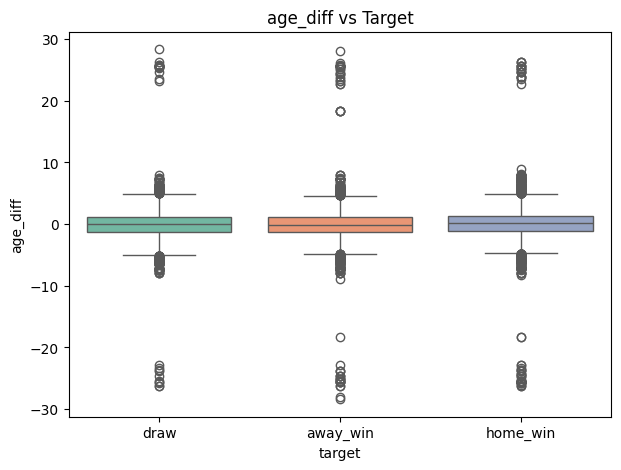

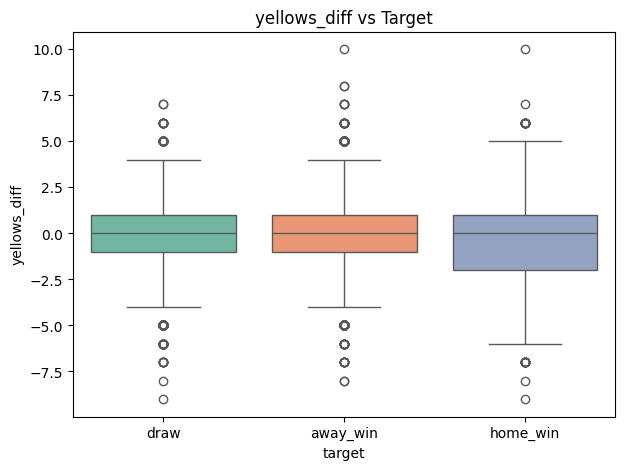

In [701]:
diff_features = ['goal_diff', 'squad_size_diff', 'age_diff', 'yellows_diff']

for f in diff_features:
    plt.figure(figsize=(7,5))
    sns.boxplot(x='target', y=f, data=df, hue='target', palette='Set2')
    plt.title(f'{f} vs Target')
    plt.show()

### Heatmap

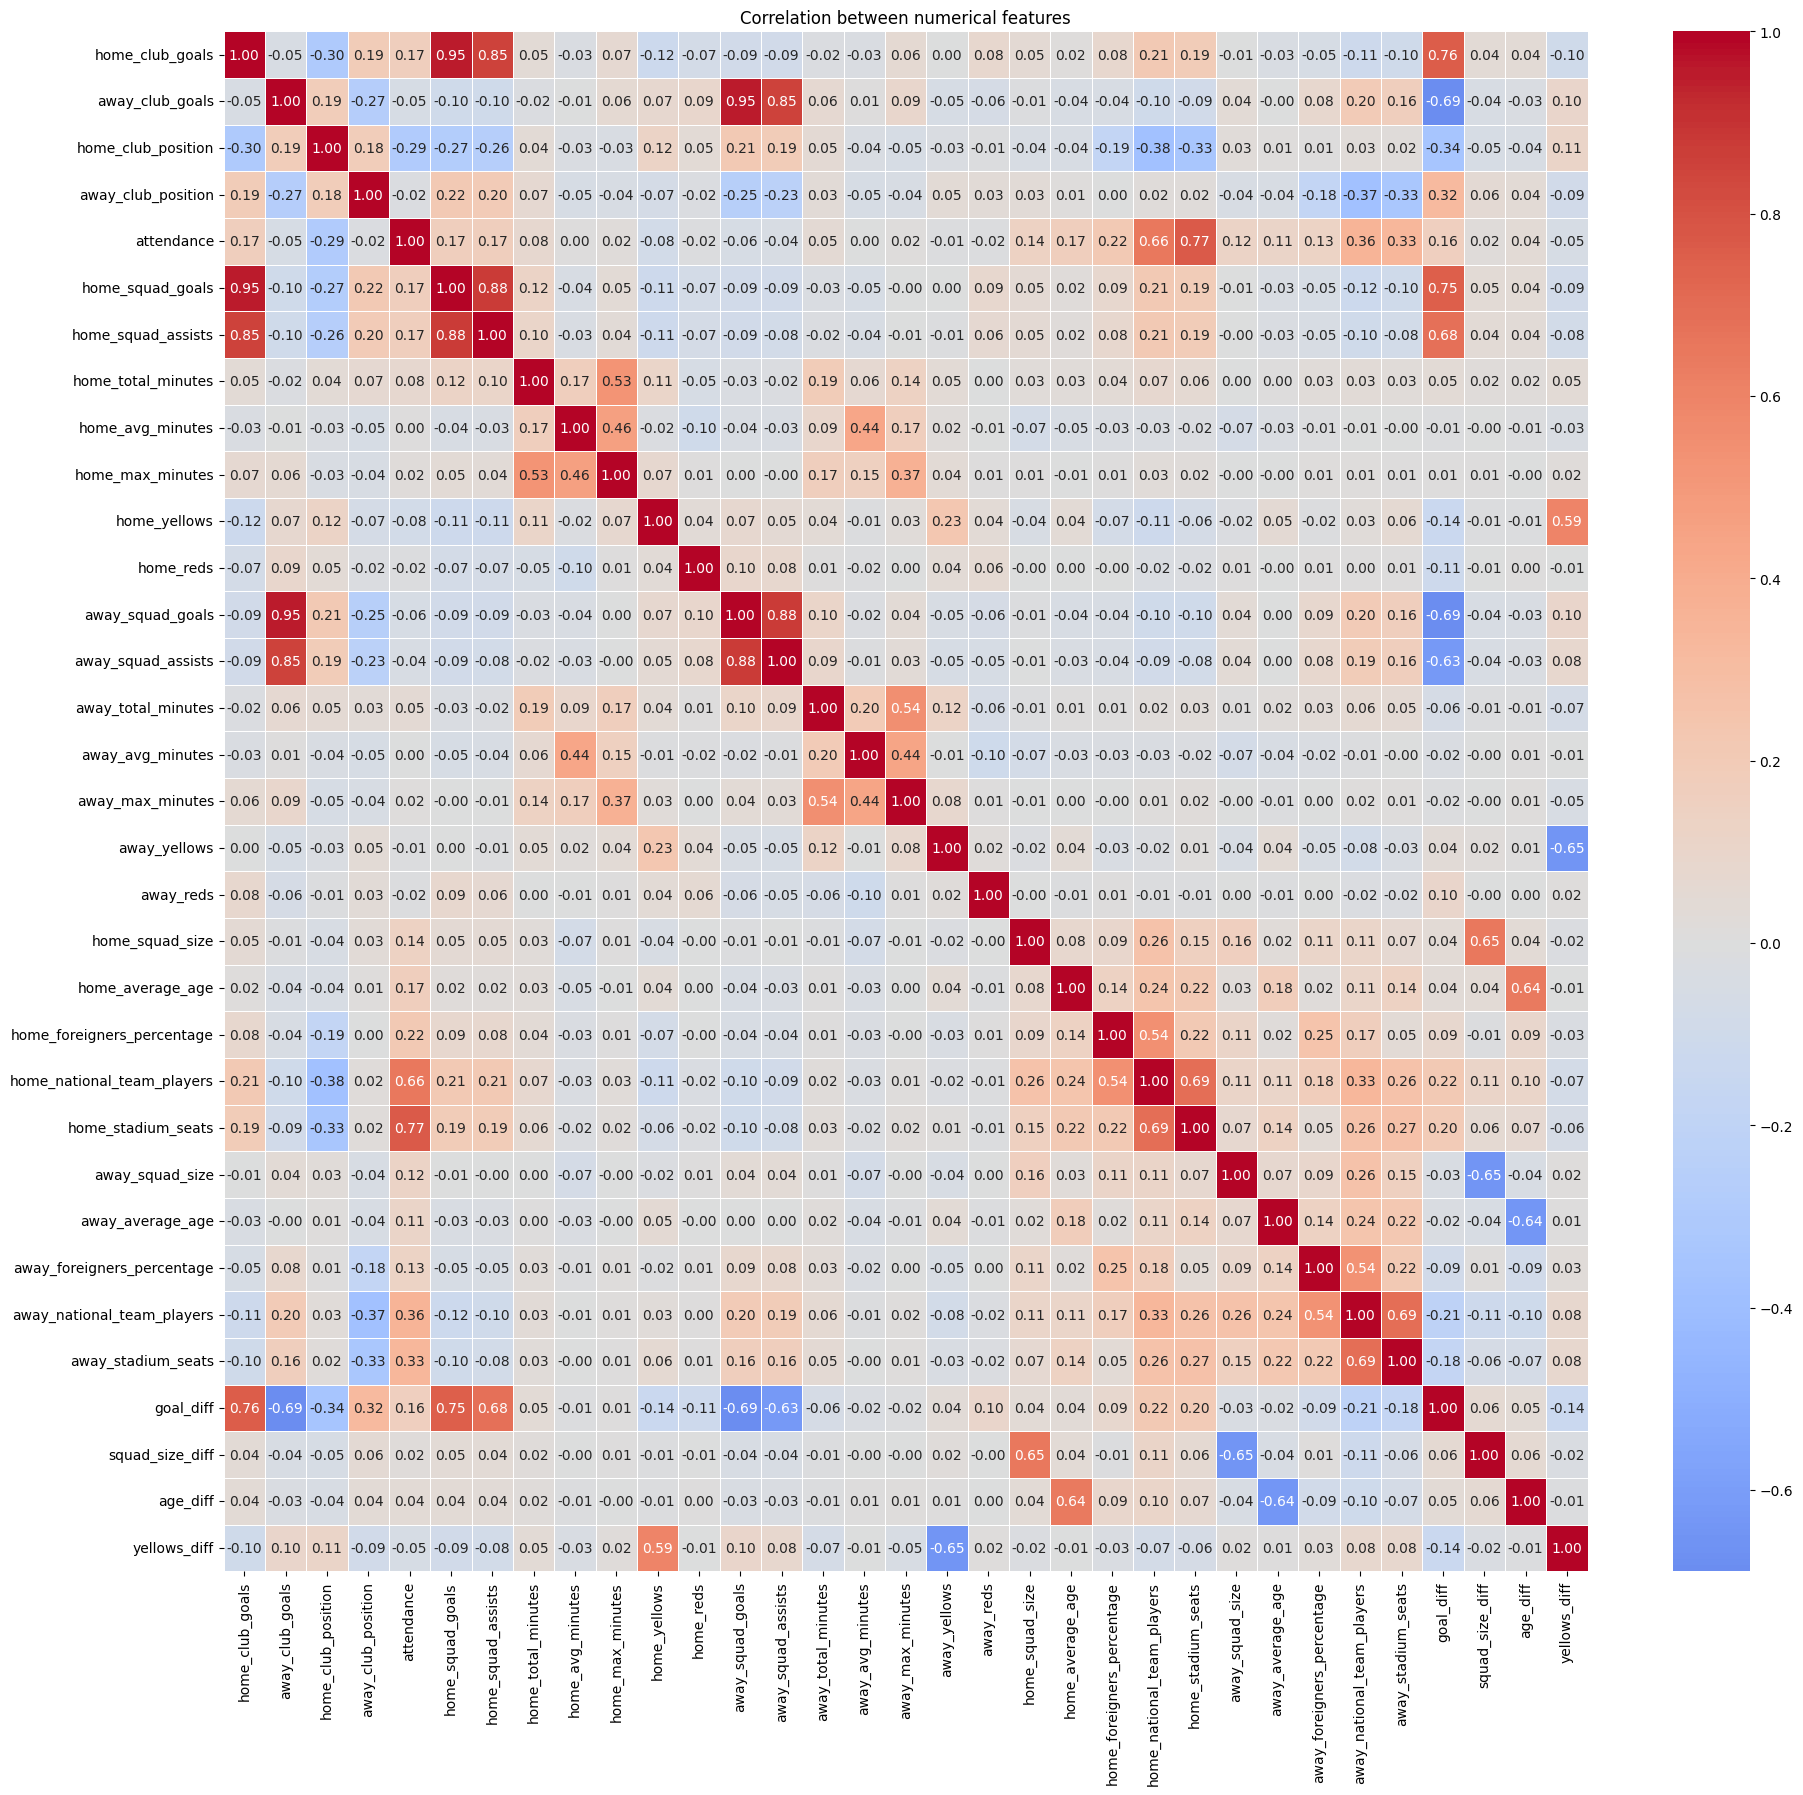

In [702]:
columns_to_drop = ['game_id', 'season', 'home_club_id', 'away_club_id', 'home_last_season', 'away_last_season' ]
numeric_features = df.select_dtypes(include=['int64', 'float64']).drop(columns=columns_to_drop).columns

plt.figure(figsize=(22,20))
corr = df[numeric_features].corr()

sns.heatmap(
    corr, 
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    annot=True,
    fmt=".2f"
)
plt.title('Correlation between numerical features')
plt.show()

# Filtering Data

In [703]:
df_model = df.copy()

drop_features = [
    'home_squad_goals', 'home_squad_assists',
    'away_squad_goals', 'away_squad_assists',
    'home_club_goals', 'away_club_goals',
    'home_stadium_seats'
]

df_model.drop(columns=drop_features, inplace=True)
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57256 entries, 0 to 59590
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   game_id                       57256 non-null  int64         
 1   competition_id                57256 non-null  object        
 2   season                        57256 non-null  int64         
 3   date                          57256 non-null  datetime64[ns]
 4   home_club_id                  57256 non-null  int64         
 5   away_club_id                  57256 non-null  int64         
 6   home_club_position            57256 non-null  int64         
 7   away_club_position            57256 non-null  int64         
 8   attendance                    57256 non-null  int64         
 9   target                        57256 non-null  object        
 10  home_total_minutes            57256 non-null  float64       
 11  home_avg_minutes              572

In [704]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

In [705]:
X = df.drop(columns=['target', 'game_id', 'home_club_id', 'away_club_id', 'date'])
X.head()

,competition_id,season,home_club_goals,away_club_goals,home_club_position,away_club_position,attendance,home_squad_goals,home_squad_assists,home_total_minutes,...,away_national_team_players,away_stadium_seats,away_last_season,goal_diff,squad_size_diff,age_diff,yellows_diff,year,month,day
0,L1,2013,3,3,8,9,61973,3.0,3.0,990.0,...,4.0,57000.0,2017.0,0,-3.0,2.8,-1.0,2013,8,11
1,L1,2013,0,1,13,7,23000,0.0,0.0,990.0,...,6.0,42100.0,2024.0,-1,3.0,-1.0,1.0,2013,8,10
2,L1,2013,2,1,1,15,80200,2.0,2.0,991.0,...,2.0,23325.0,2013.0,1,-2.0,-0.4,-1.0,2013,8,18
3,L1,2013,0,2,18,11,23325,0.0,0.0,990.0,...,10.0,58000.0,2024.0,-2,3.0,0.2,1.0,2013,8,25
4,L1,2013,6,2,1,15,80645,6.0,5.0,990.0,...,4.0,57000.0,2017.0,4,-2.0,1.6,-4.0,2013,9,14


In [706]:
X['competition_id']

0         L1
1         L1
2         L1
3         L1
4         L1
        ... 
59586    NL1
59587    NL1
59588    NL1
59589    NL1
59590    NL1
Name: competition_id, Length: 57256, dtype: object

In [707]:
categorical_cols = ['competition_id', 'home_domestic_competition_id', 'away_domestic_competition_id']
X = pd.get_dummies(X, columns=categorical_cols)

In [708]:
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
X_scaled = X.copy()
X_scaled[numeric_cols] = StandardScaler().fit_transform(X[numeric_cols])

In [709]:
X.head()

,season,home_club_goals,away_club_goals,home_club_position,away_club_position,attendance,home_squad_goals,home_squad_assists,home_total_minutes,home_avg_minutes,...,away_domestic_competition_id_GB1,away_domestic_competition_id_GR1,away_domestic_competition_id_IT1,away_domestic_competition_id_L1,away_domestic_competition_id_NL1,away_domestic_competition_id_PO1,away_domestic_competition_id_RU1,away_domestic_competition_id_SC1,away_domestic_competition_id_TR1,away_domestic_competition_id_UKR1
0,2013,3,3,8,9,61973,3.0,3.0,990.0,76.153846,...,False,False,False,True,False,False,False,False,False,False
1,2013,0,1,13,7,23000,0.0,0.0,990.0,70.714286,...,False,False,False,True,False,False,False,False,False,False
2,2013,2,1,1,15,80200,2.0,2.0,991.0,70.785714,...,False,False,False,True,False,False,False,False,False,False
3,2013,0,2,18,11,23325,0.0,0.0,990.0,70.714286,...,False,False,False,True,False,False,False,False,False,False
4,2013,6,2,1,15,80645,6.0,5.0,990.0,70.714286,...,False,False,False,True,False,False,False,False,False,False


In [710]:
target_mapping = {
    'home_win': 0,
    'draw': 1,
    'away_win': 2
}
y = df['target'].map(target_mapping)
y.head()

0    1
1    2
2    0
3    2
4    0
Name: target, dtype: int64

# Train/Test Split

In [711]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (45804, 109)
X_test: (11452, 109)
y_train: (45804,)
y_test: (11452,)


# Model

In [712]:
model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

In [713]:
model.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [714]:
y_pred = model.predict(X_test)

# Confusion Matrix

In [715]:
cm = confusion_matrix(y_test, y_pred)

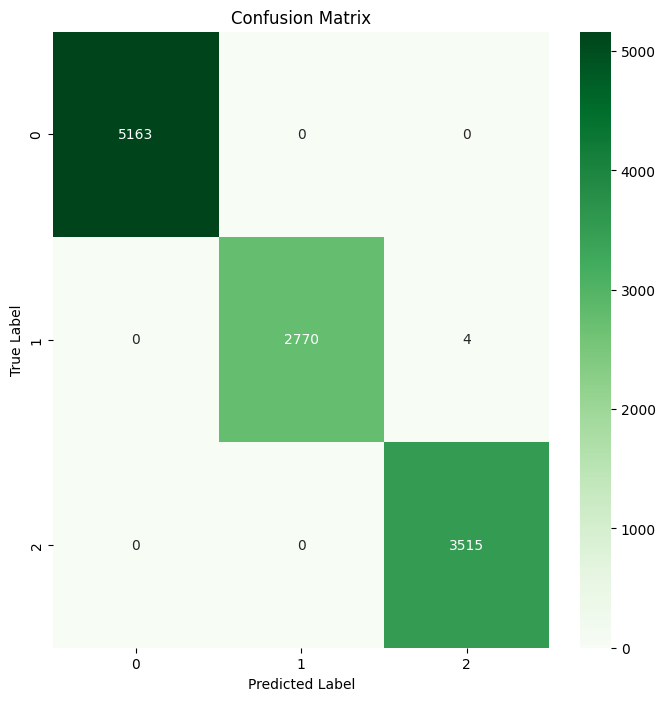

In [716]:
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [717]:
accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 99.97%
